In [263]:
import numpy as np
from scipy.fftpack import dct
from skimage.io import imread, imshow
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt

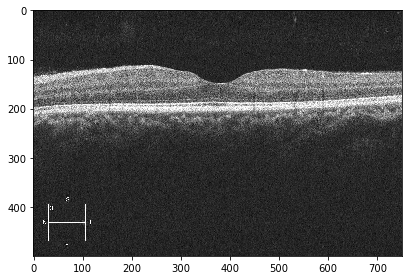

In [264]:
X = imread("NORMAL1.jpeg")
#Taking the first of the 3 channels, as they are all the same.
X = X[:,:,0]
h, w = X.shape
imshow(X)

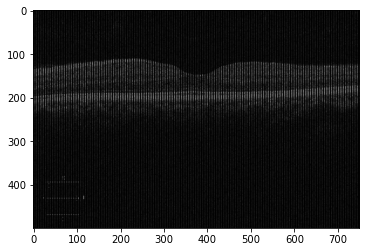

In [265]:
compression_factor = 4
mask = np.zeros((h,w))
mask[:,np.arange(0, w, compression_factor)] = 1
D = X*mask
plt.imshow(X*mask, cmap="gray")

In [266]:
# B1, S, B2t = np.linalg.svd(D, full_matrices=True)
B1 = dct(np.eye(h), norm='ortho', axis=0).T
B2t = dct(np.eye(w), norm='ortho', axis=0).T
W = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)
A = np.copy(W)
E = np.zeros_like(D)
Y1 = np.zeros_like(D)
Y2 = np.zeros_like(D)
nu1 = 3
nu2 = 3
mu = 0.5
lmda = 0.001
a = 0.85
ro = 1.01
# plt.imshow(B1 @ W @ B2t)

In [267]:
def SoftThresh(x, tau):
    # numpy automatically applies functions to each element of the array
    return np.sign(x)*np.maximum(0, np.abs(x) - tau)

def ShrinkageOperator(X, tau):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S = np.diag(SoftThresh(S,tau))
    return U @ S @ Vt

def Proj(X, mask):
    return X*(mask == 1)

def AUpdate(W, Y1, mu):
    Z = W - (1/mu)*Y1
    return ShrinkageOperator(Z, 1/mu)

def WUpdate(mask, A, W, E, D, B1, B2t, Y1, Y2, mu, nu1, lmda):
    Z = B1 @ W @ B2t + E - D + (1/mu)*Y2
    Z = Proj(Z, mask)
    Z = B1.T @ Z @ B2t.T + W - A - (1/mu)*Y1
    Z = W - (1/nu1)*Z
    return SoftThresh(Z, lmda/(nu1*mu))

def EUpdate(mask, W, E, D, B1, B2t, Y2, mu, nu2, a):
    Z = E + B1 @ W @ B2t - D
    Z = Proj(Z, mask) + (1/mu)*Y2
    Z =  E - (1/nu2)*Z
    return SoftThresh(Z, a/(mu*nu2))

def Y1Update(mask, W, E, D, B1, B2t, Y1, mu):
    Z = B1 @ W @ B2t + E - D
    return Y1 + mu*Proj(Z, mask)

def Y2Update(A, W, Y2, mu):
    return Y2 + mu*(A - W)

def muUpdate(mu, ro):
    return mu*ro


In [268]:
iters = 2000
for i in range(iters):
    A = AUpdate(W, Y1, mu)
    W = WUpdate(mask, A, W, E, D, B1, B2t, Y1, Y2, mu, nu1, lmda)
    E = EUpdate(mask, W, E, D, B1, B2t, Y2, mu, nu2, a)
    Y1 = Y1Update(mask, W, E, D, B1, B2t, Y1, mu)
    Y2 = Y2Update(A, W, Y2, mu)
    mu = muUpdate(mu, ro)
    print(np.linalg.norm(B1 @ W @ B2t - X), np.linalg.norm(W, ord="nuc"))
    



40909.076309620614 92044.28604060187
40909.078870660705 91985.367304569
40909.08398030526 91963.84282337621
40909.09588090543 91926.9514148834
40909.12440667712 91797.11915559987
40909.19841951526 91481.12523143865
40909.40054735282 90847.11729287148
40909.96505290038 89683.09323513553
40911.553171351574 87649.074128678
40915.96207719269 84263.2629248538
40928.154033337094 79001.44254359121
40962.75152675718 72515.7174689641
41064.877971831025 69354.43603700322
41376.70632022997 80521.0206167752
42346.11134277812 125423.38749984639
45327.11273753671 229036.06884383113
53921.065481251935 429679.3935297702
75606.5623588182 805468.721765955
122575.11742436227 1497121.5600512824
214501.45925831748 2764298.9111679485
386670.4707016131 5091763.881638388
704417.7893693782 9377073.723185908
1288501.2628524753 17244437.64325709
2361560.880716507 31689451.386904582
4333906.738211154 58231422.075967245
7962082.169410692 107040316.2031904
14642120.943156147 196869598.8596591
26952334.97383558 3623

KeyboardInterrupt: 

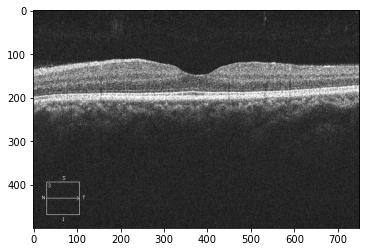

In [ ]:
plt.imshow(B1 @ W @ B2t, cmap="gray")

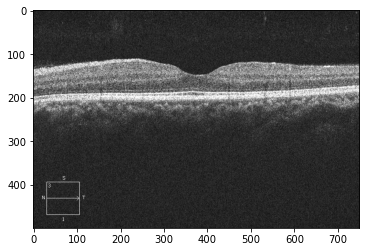

In [ ]:
plt.imshow(X, cmap="gray")

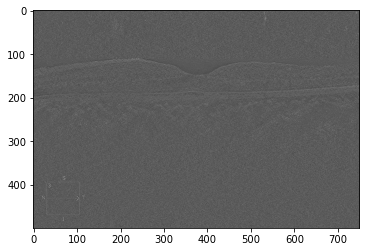

In [ ]:
plt.imshow(X - B1 @ W @ B2t, cmap="gray")